In [6]:
# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import *
from matplotlib.widgets import Slider

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ddgclib._complex import Complex
from ddgclib import *
from ddgclib._complex import *
from ddgclib._curvatures import * #plot_surface#, curvature
from ddgclib._capillary_rise_flow import * #plot_surface#, curvature
from ddgclib._hyperboloid import *
from ddgclib._catenoid import *
from ddgclib._catenoid_error import *
from ddgclib._cylinder import *
from ddgclib._cylinder_shearing import *
from ddgclib._truncated_cone import *
from ddgclib._ellipsoid import *
from ddgclib._eos import *
from ddgclib._misc import *
from ddgclib._plotting import *
#from ddgclib._case2 import *

def curvature(v):
    F, nn = vectorise_vnn(v)
    #curvature_dict = b_curvatures_hn_ij_c_ij(F, nn)
    curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    HNdA_i = curvature_dict['HNdA_i']
    return HNdA_i

# Parameters for
# a water droplet in air at standard laboratory conditions
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

# Numerical parameters #Stated this is what to plaay
r = 1
theta_p = 20 * np.pi/180.0  # rad, three phase contact angle

refinement=3# NOTE: 2 is the minimum refinement needed for the complex to be manifold

angle = 90
shear = 1

r_l = 2
r_u = 2

v_l = 1e-10
v_l = 0
v_u = 3

r_l = 2
r_u = 2

In [7]:
'''
in this part of the code, the boundarys will be closed with the function close_boundary.

'''
def close_boundary(HC, boundary_top, boundary_bottom):
    v_avg_top = np.zeros(3)
    for v in boundary_top:
        v_avg_top += v.x_a

    v_avg_top = v_avg_top/len(boundary_top)
    v_avg_bottom = np.zeros(3)
    for v in boundary_bottom:
        v_avg_bottom += v.x_a

    v_avg_bottom = v_avg_bottom/len(boundary_bottom)

    vat = HC.V[tuple(v_avg_top)]
    for v in boundary_top:
        v.connect(vat)

    vab = HC.V[tuple(v_avg_bottom)]
    for v in boundary_bottom:
        v.connect(vab)

#    boundary_top.add(vat) # from stefan
#    boundary_bottom.add(vab) # from stefan

    boundary_top.append(vat)
    boundary_bottom.append(vab)
    return HC, boundary_top, boundary_bottom

                 self.simplices_fm, A list of (dim + 1)-lists containing vertex
                                    objects in a simplex.

                 self.simplices_fm_i, Same as self.simplices_fm except contains
                                      the indices corresponding to the list in
                                      self.vertices_fm

# Functions

In [8]:
def fun_liquid_bridge(r_l, r_u, v_l, v_u,tau, t_f,d):
    '''
    v_l = lower left coordiante
    v_u = uper rigth coordinate
    tau = size of time step
    t_f = breaking condition in the while-loop = last time step
    d = diameter of the initial cyliner
    '''

    t = 0  #  initial time (=constant)
    a = d


    b, c = 0, 1  # Geometric parameters of the catenoid; can also be modified
    abc = (a, b, c)
    u_l, u_u = 0 ,2 * np.pi

    '''
    -----------------------------------------------------------
    From here, the mesh for an open cylinder is meshed
    '''

    #HC, bV, K_f, H_f, neck_verts, neck_sols = catenoiderror_N(r, theta_p, gamma, abc,u_l, u_u, v_l, v_u, refinement=refinement, cdist=1e-5, equilibrium=True)
    #HC, bV, K_f, H_f, neck_verts, neck_sols = cylinder_shearing_N(r, theta_p, gamma, abc ,shear,angle,u_l, u_u, v_l,v_u, refinement=refinement, cdist=1e-10, equilibrium=True)
    HC, bV, K_f, H_f, neck_verts, neck_sols = truncated_cone(r_l, r_u,abc, v_l, v_u, refinement)
    '''
    -----------------------------------------------------------
    closing the open mesh
    '''

    # Define bottom boundary condition
    boundary_bottom = []
    for v in HC.V:
        if v.x[2] == v_l:
            boundary_bottom.append(v)

    # Define top boundary condition
    boundary_top = []
    for v in HC.V:
        if v.x[2] == v_u:
            boundary_top.append(v)

    HC, boundary_top, boundary_bottom = close_boundary(HC, boundary_top, boundary_bottom)
    '''
    ----------------------------------------------------
    Dummy parameter for the residual
    '''
    # runvariable for the iteration tracking
    residual_iteration = 0
    iteration_list = []

    # list to track the progress from df
    df_list_max = []
    df_list_min = []

    # list to track the progress of HNdA
    dHNdA_list_min = []
    dHNdA_list_max = []
    '''
    -----------------------------------------------------------
    From here, the optimization is started
    '''

    while t < t_f:
        # Loop through all interior vertices
        # calculating the volume of the entire bridge

        cHCV = copy.copy(HC.V)

        # dummy list to find the maximum df
        df_list_dummy       = []
        dHNdA_list_dummy    = []
        for v in cHCV:
            # exclude boundaries
            if v in set(boundary_bottom):
                continue
            # Define top boundary condition
            if v in set(boundary_top):
                continue
            # Compute curvature for each interior vertex
            HNdA_i = curvature(v)
            # HNdA_i, V_i, N_i = ????(v)

            # split loop, compute V_total
            # start new    for v in cHCV:
            #
            #print(HNdA_i)
            # Step in time
            df = -gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)
            v_new = v.x_a - tau/2 * df
            HC.V.move(v, tuple(v_new))

            '''
            Try to implement a Residual with the mean curvature
            '''
            #print(HNdA_i)
            #print(np.linalg.norm(df))
            df_list_dummy.append(np.linalg.norm(df))
            dHNdA_list_dummy.append(np.linalg.norm(HNdA_i))
            #print(df)
        #print(HNdA_i)
        #print(max(df_list_dummy))
        # if V_ne
        # save the maximum and minimum datas for the Residuals
        df_list_max.append(max(df_list_dummy))
        df_list_min.append(min(df_list_dummy))

        # save the numbers of iteration for lately plotting
        residual_iteration = residual_iteration +1
        iteration_list.append(residual_iteration)

        dHNdA_list_max.append(max(dHNdA_list_dummy))
        dHNdA_list_min.append(min(dHNdA_list_dummy))

        t = tau + t

    return(HC, iteration_list, df_list_min, df_list_max)



# Using the Function

In [24]:
# dummy_parameter = fun_liquid_bridge(-0.5, 0.5,0.1, 100,1) # v_l, v_u, tau, tf, d

v_l = 0
v_u = 3

r_l = 2
r_u = 3


dummy_parameter = fun_liquid_bridge(r_l , r_u , v_l, v_u,0.1, 0,1) # v_l, v_u, tau, tf, d

HC = dummy_parameter[0]
iteration_list = dummy_parameter[1]
df_list_min = dummy_parameter[2]
df_list_max = dummy_parameter[3]

In [25]:
plot_polyscope(HC)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

Text(0.5, 1.0, 'Residuals for HNdA')

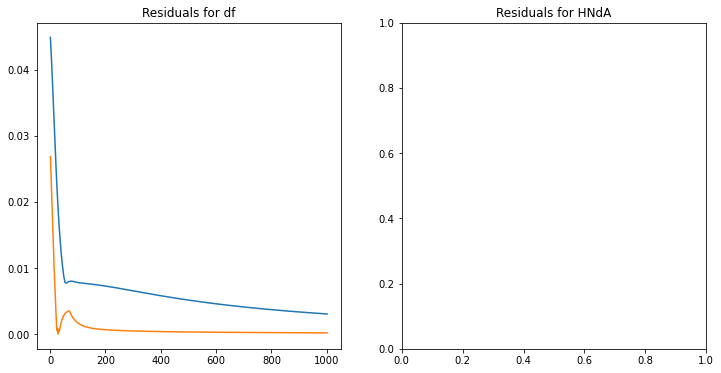

In [20]:
'''
Plot of the residual data
'''
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))


ax[0].plot(iteration_list, df_list_max)
ax[0].plot(iteration_list, df_list_min)

#ax[1].plot(iteration_list, dHNdA_list_max)
#ax[1].plot(iteration_list, dHNdA_list_min)



ax[0].set_title('Residuals for df')
ax[1].set_title('Residuals for HNdA')

In [7]:
plot_polyscope(HC)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
self.V[v].index = 0
self.V[v].index = 1
self.V[v].index = 2
self.V[v].index = 3
self.V[v].index = 4
self.V[v].index = 5
self.V[v].index = 6
self.V[v].index = 7
self.V[v].index = 8
self.V[v].index = 9
self.V[v].index = 10
self.V[v].index = 11
self.V[v].index = 12
self.V[v].index = 13
self.V[v].index = 14
self.V[v].index = 15
self.V[v].index = 16
self.V[v].index = 17
self.V[v].index = 18
self.V[v].index = 19
self.V[v].index = 20
self.V[v].index = 21
self.V[v].index = 22
self.V[v].index = 23
self.V[v].index = 24
self.V[v].index = 25
self.V[v].index = 26
self.V[v].index = 27
self.V[v].index = 28
self.V[v].index = 29